# Batch inference

Performing individual inference requests is inefficient, as the inference process is essentially sequential and memory-bound.

We can batch requests for better GPU utilization and throughput.

Run the script `run_batch_experiment.sh` to perform inference requests with different batch sizes.


## Comparing the results


Let's extract some stats from the output of the batch experiments.


In [13]:
import pandas as pd
import re
import numpy as np

batch_index = [1, 2, 4, 8, 16, 32, 64]
df_throughput = pd.DataFrame(index=batch_index)

for model in ["mixtral", "llama2"]:
    for i in batch_index:
        input_size = "32" if i == 32 else "64" if i == 64 else "16"
        out_file_name = f"./out/{model}_{input_size}_{i}.out"
        with open(out_file_name, "r") as out_file:
            text = out_file.read()
            pattern = "at ([0-9\\.]*) tokens/second"
            matches = re.findall(pattern, text)
            df_throughput.at[i, model] = float(matches[0])

df_throughput


,mixtral,llama2
1,11.21,9.19
2,11.38,10.21
4,16.59,17.72
8,23.76,28.67
16,34.70,42.75
32,47.05,53.53
64,57.82,66.65


Let's plot those numbers to obtain a view of output tokens/second for both models for different batch sizes.

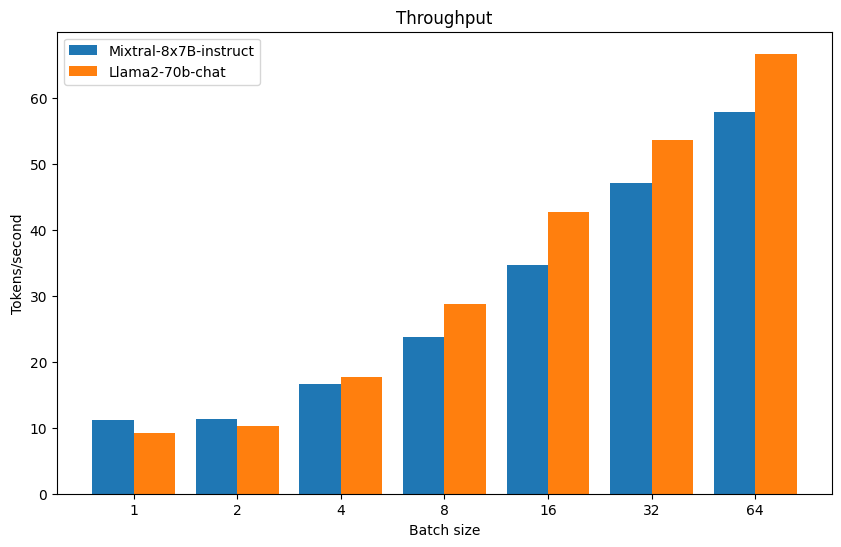

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plot_index = [x for x in range(0,len(batch_index))]
index_mixtral = [x-0.2 for x in plot_index]
index_llama2 = [x+0.2 for x in plot_index]
plt.bar(index_mixtral, df_throughput["mixtral"], label='Mixtral-8x7B-instruct', width=0.4)
plt.bar(index_llama2, df_throughput["llama2"], label='Llama2-70b-chat', width=0.4)
plt.xticks(plot_index, labels=batch_index)
plt.xlabel('Batch size')
plt.ylabel('Tokens/second')
plt.title('Throughput')
plt.legend()
plt.show()

Mixtral has better throughput up to batch size 2, whereas Llama2 gets better throughput for higher batch sizes.

Let's examine what this means in terms of speedup vs. batch size

In [15]:
df_speedup = pd.DataFrame(index=batch_index)

df_speedup["ideal"] = batch_index
df_speedup["mixtral"] = df_throughput["mixtral"] / df_throughput.at[1,"mixtral"]
df_speedup["llama2"] = df_throughput["llama2"].apply(lambda x: (x / df_throughput.at[1, "llama2"]) if x != 0.0 else np.nan)
df_speedup

,ideal,mixtral,llama2
1,1,1.000000,1.000000
2,2,1.015165,1.110990
4,4,1.479929,1.928183
8,8,2.119536,3.119695
16,16,3.095450,4.651795
32,32,4.197145,5.824810
64,64,5.157895,7.252448


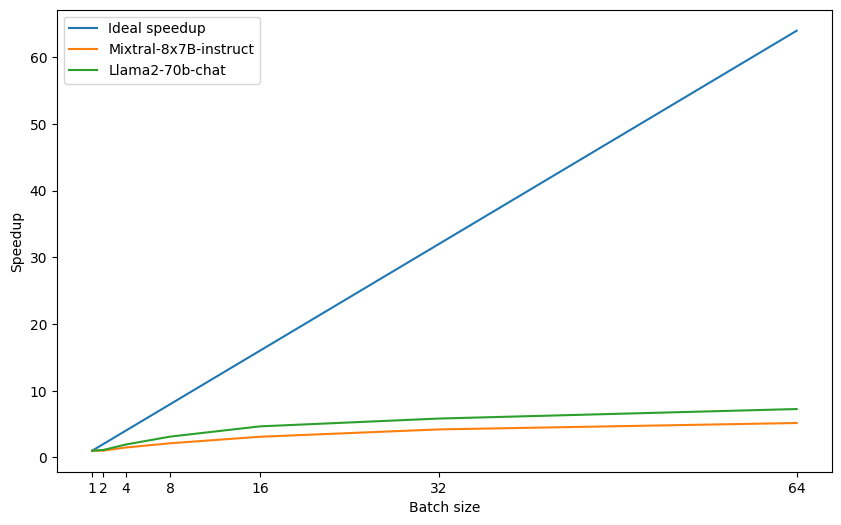

In [16]:
plt.figure(figsize=(10,6))
plt.plot(df_speedup["ideal"], label="Ideal speedup")
plt.plot(df_speedup["mixtral"], label='Mixtral-8x7B-instruct')
plt.plot(df_speedup["llama2"], label='Llama2-70b-chat')
plt.xticks(batch_index)
plt.xlabel('Batch size')
plt.ylabel('Speedup')
plt.legend()
plt.show()

Llama2 offers better speedup with batch size, meaning that it improves closer to the ideal when increasing the batch size, but it can't go past batch size 16, whereas Mixtral can go up to 32 batch size, though the speedup plateaus at 16 batch size.